In [1]:
# Data manipulation and analysis
import pandas as pd
import numpy as np

# Data visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Regular expressions and string processing
import re
import string

# ==== NLP Libraries ====
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer

# ==== Machine Learning Libraries ====
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC
from sklearn.utils.class_weight import compute_class_weight
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

# Download essential NLTK resources (run once, comment out after first run)
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')

# Set up plot aesthetics for better visuals
plt.style.use('ggplot')
sns.set(style='whitegrid')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\osorn\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\osorn\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\osorn\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


**Loading the dataset**

In [3]:
import pandas as pd

splits = {'train': 'data/train-00000-of-00001.parquet', 'validation': 'data/validation-00000-of-00001.parquet', 'test': 'data/test-00000-of-00001.parquet'}
df_train = pd.read_parquet("hf://datasets/google-research-datasets/poem_sentiment/" + splits["train"])
df_validation = pd.read_parquet("hf://datasets/google-research-datasets/poem_sentiment/" + splits["validation"])
df_test = pd.read_parquet("hf://datasets/google-research-datasets/poem_sentiment/" + splits["test"])

In [4]:
!pip install nlpaug

d: index of the example

verse_text: The text of the poem verse

label: The sentiment label.
Here

0 = negative

1 = positive

2 = no impact

3 = mixed (both negative and positive)


Note: The original dataset uses different label indices (negative = -1, no impact = 0, positive = 1)

In [5]:

# Display basic information
print("Training data shape:", df_train.shape)
print("Test data shape:", df_test.shape)
print("Validation data shape:", df_validation.shape)

# Preview the first few rows of the training data
print("\nFirst 5 rows of training data:")
display(df_train.head(10))

Training data shape: (892, 3)
Test data shape: (104, 3)
Validation data shape: (105, 3)

First 5 rows of training data:


,id,verse_text,label
0,0,with pale blue berries. in these peaceful shad...,1
1,1,"it flows so long as falls the rain,",2
2,2,"and that is why, the lonesome day,",0
3,3,"when i peruse the conquered fame of heroes, an...",3
4,4,of inward strife for truth and liberty.,3
5,5,the red sword sealed their vows!,3
6,6,and very venus of a pipe.,2
7,7,"who the man, who, called a brother.",2
8,8,"and so on. then a worthless gaud or two,",0
9,9,to hide the orb of truth--and every throne,2


In [6]:
# Check for missing values
print("\nMissing values in training data:")
print(df_train.isnull().sum())


print("\nMissing values in validation data:")
print(df_validation.isnull().sum())

print("\nMissing values in test data:")
print(df_test.isnull().sum())


Missing values in training data:
id            0
verse_text    0
label         0
dtype: int64

Missing values in validation data:
id            0
verse_text    0
label         0
dtype: int64

Missing values in test data:
id            0
verse_text    0
label         0
dtype: int64


In [7]:
#Sentiment distribution in training data

sentimientos={
    0: 'negative',
    1: 'positive',
    2: 'no impact',
    3: 'mixed'
}

df_train['sentiment']=df_train['label'].map(sentimientos)
df_test['sentiment']=df_test['label'].map(sentimientos)
df_validation['sentiment']=df_validation['label'].map(sentimientos)
df_train['sentiment'].value_counts()


sentiment
no impact    555
negative     155
positive     133
mixed         49
Name: count, dtype: int64

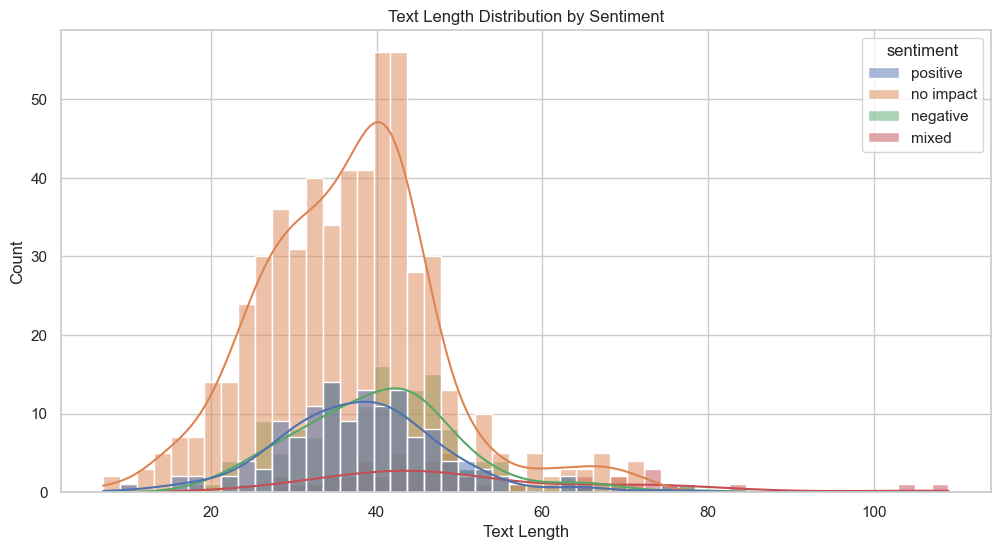

Percentile 95:  60.0
Percentile 99:  73.0


In [8]:
# Explore text length distribution
df_train['len_text'] = df_train['verse_text'].apply(len)
plt.figure(figsize=(12, 6))
sns.histplot(df_train, x='len_text', hue='sentiment', bins=50, kde=True)
plt.title('Text Length Distribution by Sentiment')
plt.xlabel('Text Length')
plt.show()

print("Percentile 95: ",np.percentile(df_train['len_text'], 95))
print("Percentile 99: ",np.percentile(df_train['len_text'], 99))

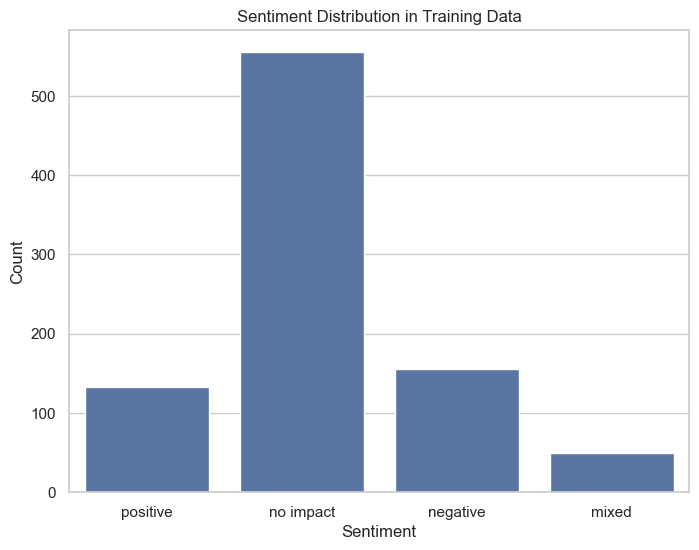

In [9]:
import matplotlib.pyplot as plt
import seaborn as sns
#Visualize sentiment distribution

plt.figure(figsize=(8, 6))
sns.countplot(data=df_train, x='sentiment')
plt.title('Sentiment Distribution in Training Data')
plt.xlabel('Sentiment')
plt.ylabel('Count')
plt.show()

In [ ]:
import nltk
  nltk.download('punkt_tab')

[nltk_data] Downloading package punkt_tab to
[nltk_data]     C:\Users\osorn\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


True

In [ ]:
# Clean and preprocess text before modeling to remove noise and standardize the input.
# This pipeline covers: lowercasing, removing URLs, HTML, mentions, hashtags, punctuation, numbers, and extra whitespace.
# Tokenization, stopword removal, and lemmatization are also included for robust NLP.

def clean_text(text):
    """
    Clean and preprocess text data.

    Args:
        text (str): Input text

    Returns:
        str: Cleaned text
    """
    if pd.isna(text):
        return ""

    # Convert to lowercase
    text = text.lower()

    # Remove URLs
    text = re.sub(r'https?://\S+|www\.\S+', '', text)

    # Remove HTML tags
    text = re.sub(r'<.*?>', '', text)

    # Remove user mentions
    text = re.sub(r'@\w+', '', text)

    # Remove hashtags (keeping the text after #)
    text = re.sub(r'#(\w+)', r'\1', text)

    # Remove punctuation
    text = text.translate(str.maketrans('', '', string.punctuation))

    # Remove numbers
    text = re.sub(r'\d+', '', text)

    # Remove extra whitespace
    text = re.sub(r'\s+', ' ', text).strip()

    return text

def preprocess_text(text):
    """
    Full preprocessing pipeline: clean, tokenize, remove stopwords, and lemmatize.

    Args:
        text (str): Input text

    Returns:
        str: Preprocessed text
    """
    if pd.isna(text):
        return ""

    # Clean text
    text = clean_text(text)

    # Tokenize
    tokens = word_tokenize(text)

    # Remove stopwords
    stop_words = set(stopwords.words('english'))
    tokens = [token for token in tokens if token not in stop_words]

    # Lemmatize
    lemmatizer = WordNetLemmatizer()
    tokens = [lemmatizer.lemmatize(token) for token in tokens]

    # Join tokens back into text
    processed_text = ' '.join(tokens)

    return processed_text

In [ ]:
# Set of stop_words
stop_words = set(stopwords.words('english'))
print(stop_words)

{'no', "you've", 'which', 'yourself', 'this', 'during', 'or', 'didn', "isn't", "wasn't", 'won', 'it', "it'd", "we're", 'above', 'into', 'they', "they've", 'is', 's', 'theirs', 'isn', 'how', 'couldn', 'most', 'mightn', 'than', 'below', 'our', 'because', 'll', 'hadn', "won't", 'as', 'same', "we'd", 't', 'both', 'against', 'you', 'few', 'but', 'don', 'nor', 've', 'has', 'have', 'all', "wouldn't", "don't", "she'll", "i've", "mustn't", 'o', 'needn', 'while', 'haven', 'through', 'some', 'now', 'yourselves', 'aren', 'shan', 'their', 'itself', 'more', 'between', 'them', 'of', 'his', 'from', "she's", "it'll", "hadn't", 'out', 'were', "he's", 'until', 'doesn', 'hers', 'be', 'ain', 'y', 'there', 'weren', 'mustn', 'before', 'having', 'will', "that'll", 'who', 'that', "you'll", 'ourselves', 'should', 'ma', 'we', "i'm", 'after', 'themselves', 'an', "they'd", "we've", 'just', "she'd", 'why', 'her', 'further', 'only', 'was', 'd', 'he', 'each', 'at', 'and', "he'd", 'a', "aren't", 'me', 'your', "should'

In [ ]:
#apply preprocessing function to train,validation and test data
df_train['processed_text'] = df_train['verse_text'].apply(preprocess_text)
df_validation['processed_text'] = df_validation['verse_text'].apply(preprocess_text)
df_test['processed_text'] = df_test['verse_text'].apply(preprocess_text)

#Original vs preprocessed text
for i in range(3):
  print(f"Original Text: {df_train['verse_text'][i]}")
  print(f"Processed Text: {df_train['processed_text'][i]}")

Original Text: with pale blue berries. in these peaceful shades--
Processed Text: pale blue berry peaceful shade
Original Text: it flows so long as falls the rain,
Processed Text: flow long fall rain
Original Text: and that is why, the lonesome day,
Processed Text: lonesome day


In [ ]:
  import nltk
  nltk.download('averaged_perceptron_tagger_eng')

[nltk_data] Downloading package averaged_perceptron_tagger_eng to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger_eng.zip.


True

In [ ]:
# Applying random augmentations

import nlpaug.augmenter.word as naw
import random
import numpy as np
import nlpaug

SEED = 42
random.seed(SEED)
np.random.seed(SEED)


#Minority classes
minority_classes=["negative","positive","mixed"]

print("Original distribution: ", df_train['sentiment'].value_counts())

label_col="sentiment"
text_col="processed_text"



aug= naw.SynonymAug(aug_src='wordnet')
augmented_data = []

for label in df_train[label_col].unique():
  subset=df_train[df_train[label_col]==label]

  #Augment 5 times majority classes
  if label not in minority_classes:
    for _,row in subset.iterrows():
      for i in range(4):
        augmented_text=aug.augment(row[text_col])
        print("Original text: ", row[text_col])
        if augmented_text:
          stru=augmented_text[0]
        else:
          stru=row[text_col]
        print("Augmented text: ", stru)
        augmented_data.append({text_col:stru,label_col:label})
  #Augment 14 times minority classes:
  else:
    for _,row in subset.iterrows():
      for i in range(14):
        augmented_text=aug.augment(row[text_col])
        print("Original:", row[text_col])
        if augmented_text:
          stru=augmented_text[0]
        else:
          stru=row[text_col]
        print("Augmented text: ",stru)
        augmented_data.append({text_col:stru,label_col:label})


df_augmented=pd.concat([df_train,pd.DataFrame(augmented_data)],ignore_index=True)
print("New distribution:", df_augmented[label_col].value_counts())

df_augmented.to_csv("augmented_data.csv",index=False)

Se truncaron las últimas líneas 5000 del resultado de transmisión.
Original: sha nt roll yo eye
Augmented text:  sha nt curlicue yo optic
Original: sha nt roll yo eye
Augmented text:  sha nt roll yo oculus
Original: sha nt roll yo eye
Augmented text:  sha nt roll yo eye
Original: sha nt roll yo eye
Augmented text:  sha nt roll yo eye
Original: sha nt roll yo eye
Augmented text:  sha nt cast yo eye
Original: flight seditious angel receave
Augmented text:  flight incendiary angel receave
Original: flight seditious angel receave
Augmented text:  trajectory incitive angel receave
Original: flight seditious angel receave
Augmented text:  flight of stairs seditious backer receave
Original: flight seditious angel receave
Augmented text:  flight subversive holy person receave
Original: flight seditious angel receave
Augmented text:  flight of stairs seditious angel receave
Original: flight seditious angel receave
Augmented text:  trajectory subversive angel receave
Original: flight seditious a

In [ ]:
df_augmented=df_augmented.drop(columns=['id','verse_text','label'])
df_augmented.head()

labels={
     "negative":0,
    "positive":1,
    "no impact":2,
    "mixed":3
}

df_augmented['label']=df_augmented['sentiment'].map(labels)
df_augmented.head()


,sentiment,len_text,processed_text,label
0,positive,50.0,pale blue berry peaceful shade,1
1,no impact,35.0,flow long fall rain,2
2,negative,34.0,lonesome day,0
3,mixed,109.0,peruse conquered fame hero victory mighty gene...,3
4,mixed,39.0,inward strife truth liberty,3


In [ ]:
df_test=df_test.dropna(subset=['verse_text','sentiment'])

In [ ]:
df_test

,id,verse_text,label,sentiment,processed_text
0,0,"my canoe to make more steady,",2,no impact,canoe make steady
1,1,and be glad in the summer morning when the kin...,1,positive,glad summer morning kindred ride way
2,2,and when they reached the strait symplegades,2,no impact,reached strait symplegades
3,3,she sought for flowers,2,no impact,sought flower
4,4,"if they are hungry, paradise",2,no impact,hungry paradise
...,...,...,...,...,...
99,99,shall live my highland mary.,2,no impact,shall live highland mary
100,100,now is past since last we met,2,no impact,past since last met
101,101,begins to live,2,no impact,begin live
102,102,beneath the hazel bough;,2,no impact,beneath hazel bough


In [ ]:

# Count Vectorizer configuration
CountVect=CountVectorizer(max_features=10000,ngram_range=(1,2))
X_train_cv=CountVect.fit_transform(df_augmented['processed_text'])

X_test_cv=CountVect.transform(df_test['processed_text'])
X_val_cv=CountVect.transform(df_validation['processed_text'])
y_train=df_augmented['label']
y_test=df_test['label']
y_val=df_validation['label']

print("After countvectorizer X_train: ", X_train_cv.shape)
print("After countvectorizer X_test: ", X_test_cv.shape)
print("After countvectorizer X_val: ", X_val_cv.shape)

print("X_train: ", X_train_cv)
print("y_train: ", y_train)



After countvectorizer X_train:  (7830, 10000)
After countvectorizer X_test:  (104, 10000)
After countvectorizer X_val:  (105, 10000)
X_train:  <Compressed Sparse Row sparse matrix of dtype 'int64'
	with 53313 stored elements and shape (7830, 10000)>
  Coords	Values
  (0, 6798)	1
  (0, 916)	1
  (0, 786)	1
  (0, 6881)	1
  (0, 7903)	1
  (0, 6799)	1
  (0, 918)	1
  (0, 789)	1
  (0, 6882)	1
  (1, 3093)	1
  (1, 4874)	1
  (1, 2672)	1
  (1, 7303)	1
  (1, 3098)	1
  (1, 4879)	1
  (1, 2682)	1
  (2, 4868)	1
  (2, 1772)	1
  (2, 4870)	1
  (3, 6943)	1
  (3, 1549)	1
  (3, 2700)	1
  (3, 3873)	1
  (3, 9471)	1
  (3, 5572)	1
  :	:
  (7828, 8197)	1
  (7828, 3779)	1
  (7828, 1278)	1
  (7828, 6682)	1
  (7828, 2100)	1
  (7828, 2925)	1
  (7828, 8201)	1
  (7828, 2101)	1
  (7828, 2926)	1
  (7828, 7069)	1
  (7828, 6684)	1
  (7828, 1279)	1
  (7829, 1282)	1
  (7829, 3779)	1
  (7829, 6682)	1
  (7829, 2100)	1
  (7829, 2925)	1
  (7829, 6685)	1
  (7829, 1283)	1
  (7829, 2101)	1
  (7829, 2926)	1
  (7829, 1964)	1
  (7829,

**Multinomial NB**

In [ ]:

model=MultinomialNB()
model.fit(X_train_cv,y_train)
y_pred=model.predict(X_test_cv)
print("Prediccion: ",y_pred)
print("Real: ", y_test)

Prediccion:  [2 1 2 2 2 0 0 2 0 2 1 0 1 2 3 0 2 1 2 2 0 1 1 2 2 0 2 2 0 0 2 2 2 1 1 0 2
 1 2 2 1 2 2 1 2 2 2 2 0 0 3 2 1 2 2 2 0 2 2 2 2 2 2 2 2 2 3 0 0 0 1 2 0 2
 2 2 0 3 2 2 0 2 0 2 0 2 2 2 0 2 2 2 2 0 1 1 2 2 2 2 2 2 2 2]
Real:  0      2
1      1
2      2
3      2
4      2
      ..
99     2
100    2
101    2
102    2
103    2
Name: label, Length: 104, dtype: int64


 Accuracy train: 0.9911
 Accuracy val: 0.6095
 Accuracy test: 0.6923

Classification Report:
              precision    recall  f1-score   support

           0       0.57      0.68      0.62        19
           1       0.53      0.50      0.52        16
           2       0.82      0.74      0.78        69
           3       0.00      0.00      0.00         0

    accuracy                           0.69       104
   macro avg       0.48      0.48      0.48       104
weighted avg       0.73      0.69      0.71       104



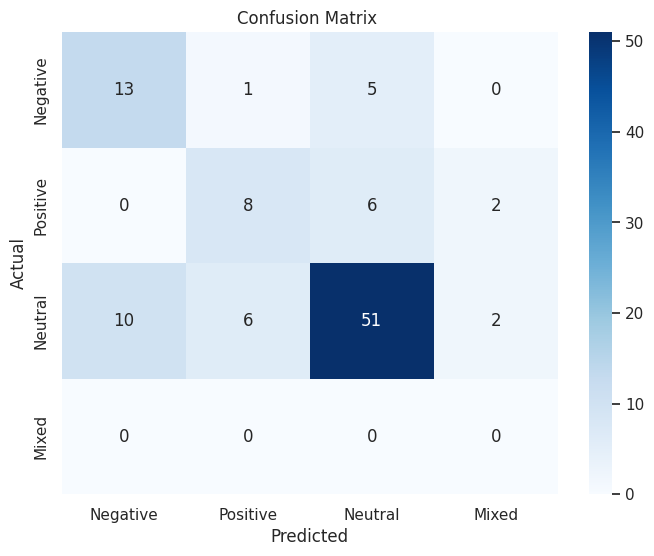

In [ ]:
#   Evaluate the mode
accuracy_train = accuracy_score(y_train, model.predict(X_train_cv))
accuracy_val=accuracy_score(y_val,model.predict(X_val_cv))
accuracy_test = accuracy_score(y_test, y_pred)
print(f" Accuracy train: {accuracy_train:.4f}")
print(f" Accuracy val: {accuracy_val:.4f}")
print(f" Accuracy test: {accuracy_test:.4f}")

  # Generate classification report
print("\nClassification Report:")
print(classification_report(y_test, y_pred,zero_division=0))

    # Generate confusion matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=['Negative', 'Positive', 'Neutral','Mixed'],
                yticklabels=['Negative', 'Positive', 'Neutral','Mixed'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title(f'Confusion Matrix ')
plt.show()

In [ ]:
#Metrics

#Confusion matrix
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))

#Classification report
print("\nClassification Report:")
print(classification_report(y_test, y_pred,zero_division=0))


Confusion Matrix:
[[13  1  5  0]
 [ 0  8  6  2]
 [10  6 51  2]
 [ 0  0  0  0]]

Classification Report:
              precision    recall  f1-score   support

           0       0.57      0.68      0.62        19
           1       0.53      0.50      0.52        16
           2       0.82      0.74      0.78        69
           3       0.00      0.00      0.00         0

    accuracy                           0.69       104
   macro avg       0.48      0.48      0.48       104
weighted avg       0.73      0.69      0.71       104



**LSTM**

In [ ]:
# Libraries
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout, Bidirectional,GRU

In [ ]:
#Preprocessing
train_texts=df_augmented['processed_text'].tolist()
test_texts=df_test['processed_text'].tolist()
val_texts=df_validation['processed_text'].tolist()

print(train_texts[0])

pale blue berry peaceful shade


In [ ]:
#Tokenization

tokenizer=Tokenizer(num_words=10000, oov_token="<OOV>")
tokenizer.fit_on_texts(train_texts)

train_sequences=tokenizer.texts_to_sequences(train_texts)
test_sequences=tokenizer.texts_to_sequences(test_texts)
val_sequences=tokenizer.texts_to_sequences(val_texts)

print(train_sequences[0])

[744, 373, 470, 824, 1022]


In [ ]:
#calculating max_len

seq_lengths=[len(seq) for seq in train_sequences]
max_len=int(np.percentile(seq_lengths,95))
print("max_len: ",max_len)

max_len:  7


In [ ]:
#padding

X_train=pad_sequences(train_sequences,maxlen=max_len,padding='post')
X_test=pad_sequences(test_sequences,maxlen=max_len,padding='post')
X_val=pad_sequences(val_sequences,maxlen=max_len,padding='post')

print("train_sequence_padded",X_train)

train_sequence_padded [[ 744  373  470 ... 1022    0    0]
 [ 222   26   85 ...    0    0    0]
 [1236    6    0 ...    0    0    0]
 ...
 [  41  674 5006 ...  675  112 2413]
 [  41  674  802 ...  675  112 1472]
 [2821  674  388 ...  675  112 2413]]


In [ ]:
#etiquetas

y_train=df_augmented['label'].values
y_test=df_test['label'].values
y_val=df_validation['label'].values

print(y_val)

[2 1 2 0 2 0 1 0 2 2 2 0 2 2 2 2 2 2 2 2 2 2 1 2 2 2 2 2 2 2 1 2 2 2 2 2 2
 2 2 2 2 1 1 2 2 2 1 2 2 2 0 2 0 2 2 2 2 0 0 2 2 2 0 1 2 1 1 1 2 2 0 0 1 0
 2 2 2 2 1 0 1 2 2 0 0 2 2 0 2 2 2 0 2 0 2 1 2 1 2 2 2 2 2 1 0]


In [ ]:
classes=np.unique(y_train)
print(classes)
cw=compute_class_weight(class_weight='balanced',classes=classes,y=y_train)
class_weights=dict(zip(classes,cw))
print(class_weights)

[0 1 2 3]
{np.int64(0): np.float64(0.8419354838709677), np.int64(1): np.float64(0.981203007518797), np.int64(2): np.float64(0.7054054054054054), np.int64(3): np.float64(2.663265306122449)}


In [ ]:
#LSTM model
new_var = 128
model = Sequential([
    Embedding(input_dim=10000, output_dim=new_var, input_length=max_len),
    LSTM(168, activation = 'tanh'),
    Dropout(0.5),
    Dense(168, activation='tanh'),
    Dropout(0.5),
    Dense(4, activation='softmax')
])




In [ ]:
#Training
import keras
model.compile(loss='sparse_categorical_crossentropy', optimizer=keras.optimizers.Adam(learning_rate=1e-5), metrics=['accuracy'])
model.summary()

Model: "sequential_8"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_8 (Embedding)         │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_8 (LSTM)                   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_16 (Dropout)            │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_16 (Dense)                │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_17 (Dropout)            │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_17 (Dense)                │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

In [ ]:
history=model.fit(X_train, y_train, epochs=10, batch_size=16, shuffle=True,validation_data=(X_val, y_val),class_weight=class_weights)

Epoch 1/10
490/490 ━━━━━━━━━━━━━━━━━━━━ 16s 25ms/step - accuracy: 0.3269 - loss: 1.3779 - val_accuracy: 0.4095 - val_loss: 1.4357
Epoch 2/10
490/490 ━━━━━━━━━━━━━━━━━━━━ 12s 25ms/step - accuracy: 0.6441 - loss: 0.7433 - val_accuracy: 0.4000 - val_loss: 1.9686
Epoch 3/10
490/490 ━━━━━━━━━━━━━━━━━━━━ 12s 24ms/step - accuracy: 0.9733 - loss: 0.0802 - val_accuracy: 0.4095 - val_loss: 2.3739
Epoch 4/10
490/490 ━━━━━━━━━━━━━━━━━━━━ 12s 25ms/step - accuracy: 0.9931 - loss: 0.0205 - val_accuracy: 0.4190 - val_loss: 2.9027
Epoch 5/10
490/490 ━━━━━━━━━━━━━━━━━━━━ 14s 28ms/step - accuracy: 0.9973 - loss: 0.0092 - val_accuracy: 0.4286 - val_loss: 3.3691
Epoch 6/10
490/490 ━━━━━━━━━━━━━━━━━━━━ 13s 25ms/step - accuracy: 0.9992 - loss: 0.0045 - val_accuracy: 0.4571 - val_loss: 3.6248
Epoch 7/10
490/490 ━━━━━━━━━━━━━━━━━━━━ 12s 25ms/step - accuracy: 0.9997 - loss: 0.0014 - val_accuracy: 0.4667 - val_loss: 3.9017
Epoch 8/10
490/490 ━━━━━━━━━━━━━━━━━━━━ 13s 26ms/step - accuracy: 0.9998 - loss: 0.0014 - 

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step
245/245 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
 Accuracy_test: 0.5000
 Accuracy_train: 0.9566
 Accuracy_val: 0.5143

Classification Report LSTM:
              precision    recall  f1-score   support

           0       0.20      0.42      0.27        19
           1       0.36      0.25      0.30        16
           2       0.75      0.58      0.66        69

    accuracy                           0.50       104
   macro avg       0.44      0.42      0.41       104
weighted avg       0.59      0.50      0.53       104



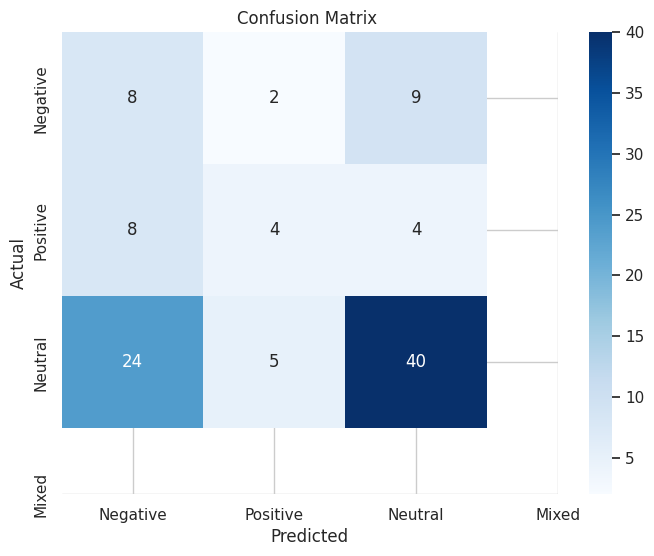

In [ ]:
#Confusion matrix

y_pred_prob = model.predict(X_test)
y_pred = y_pred_prob.argmax(axis=1)

#   Evaluate the mode
accuracy_test = accuracy_score(y_test, y_pred)
accuracy_train = accuracy_score(y_train, model.predict(X_train).argmax(axis=1))
accuracy_val = accuracy_score(y_val, model.predict(X_val).argmax(axis=1))
print(f" Accuracy_test: {accuracy_test:.4f}")
print(f" Accuracy_train: {accuracy_train:.4f}")
print(f" Accuracy_val: {accuracy_val:.4f}")

  # Generate classification report
print("\nClassification Report LSTM:")
print(classification_report(y_test, y_pred,zero_division=0))

    # Generate confusion matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=['Negative', 'Positive', 'Neutral','Mixed'],
                yticklabels=['Negative', 'Positive', 'Neutral','Mixed'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title(f'Confusion Matrix ')
plt.show()

In [ ]:
misclassified_indices = np.where(y_pred !=y_test)[0]
misclassified_examples = pd.DataFrame({
    'text': df_test.iloc[misclassified_indices]['processed_text'].values,
    'true_sentiment': y_test[misclassified_indices],
    'predicted_sentiment': y_pred[misclassified_indices]
})

print("\nSample of misclassified examples:")
display(misclassified_examples.head(20))


Sample of misclassified examples:


,text,true_sentiment,predicted_sentiment
0,indignantly hurled cry,0,2
1,house haunted,0,2
2,longuncoupled bed childless eld,2,0
3,thine bird sweet enthusiasm,1,2
4,said lost arch angel seat,2,1
5,golden cross worn innermostly carved,2,0
6,day thou even thou didst know,2,3
7,must change heavn mournful gloom,0,2
8,penance saintly styrian monk,2,1
9,oer earth wanders wide,2,0


**Logistic regression**

In [ ]:

#logistic regression

Vectorizer1=CountVectorizer(max_features=10000)
X_train_cv1=Vectorizer1.fit_transform(df_augmented['processed_text'])

print("Original X_train: ",X_train_cv1.shape)
print("Original y_train: ",y_train.shape)

X_test_cv1=Vectorizer1.transform(df_test['processed_text'])
X_val_cv1=Vectorizer1.transform(df_validation['processed_text'])


Original X_train:  (7830, 4974)
Original y_train:  (7830,)


In [ ]:
model3=LogisticRegression(max_iter=1000,class_weight='balanced')
model3.fit(X_train_cv1,y_train)
y_pred=model3.predict(X_test_cv1)
print("Prediction: ",y_pred)
print("Real: ", y_test)
print("Accuracy_train: ",model3.score(X_train_cv1,y_train))
print("Accuracy_test: ",model3.score(X_test_cv1,y_test))
print("Accuracy_val: ",model3.score(X_val_cv1,y_val))

Prediction:  [2 1 2 2 2 0 2 2 2 2 1 1 2 2 3 2 2 2 2 2 0 1 1 2 2 2 2 2 2 2 2 2 2 2 0 2 2
 2 2 2 2 2 2 2 2 2 2 2 0 0 0 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 0 2 0 2 2 2 2 2
 2 2 2 3 2 0 0 2 2 2 0 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2]
Real:  [2 1 2 2 2 0 0 2 2 2 1 2 2 2 2 0 1 2 2 2 2 1 2 2 0 0 2 2 0 0 1 2 2 2 1 0 2
 2 2 1 2 2 2 1 2 2 2 0 0 0 1 2 0 2 0 2 2 2 2 2 2 1 1 2 0 2 2 2 0 2 1 2 2 1
 2 2 2 1 2 2 0 2 2 2 0 2 2 2 0 2 2 2 0 2 1 1 2 2 2 2 2 2 2 2]
Accuracy_train:  0.9983397190293742
Accuracy_test:  0.6923076923076923
Accuracy_val:  0.6571428571428571


Confusion Matrix:
[[ 6  0 13  0]
 [ 2  3 11  0]
 [ 2  2 64  1]
 [ 0  0  0  0]]

Classification Report:
              precision    recall  f1-score   support

           0       0.60      0.32      0.41        19
           1       0.60      0.19      0.29        16
           2       0.73      0.93      0.82        69
           3       0.00      0.00      0.00         0

    accuracy                           0.70       104
   macro avg       0.48      0.36      0.38       104
weighted avg       0.68      0.70      0.66       104



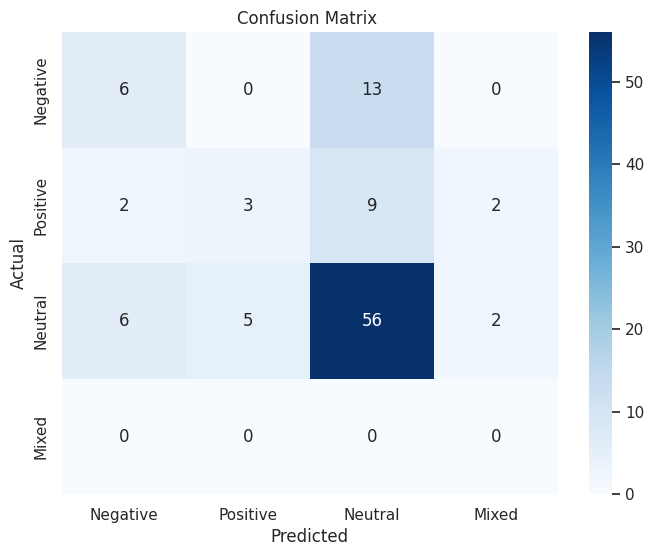

In [ ]:
#Confusion matrix

print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))

#Classification report
print("\nClassification Report:")
print(classification_report(y_test, y_pred,zero_division=0))

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=['Negative', 'Positive', 'Neutral','Mixed'],
                yticklabels=['Negative', 'Positive', 'Neutral','Mixed'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title(f'Confusion Matrix ')
plt.show()